# Задача 
В парикмахерской работают 3 мастера, а в зале ожидания расположены 3 стула. Поток клиентов имеет интенсивность 12 клиентов в час. Среднее время обслуживания составляет 20 мин. Определить показатели работы СМО.

# Решение

In [1]:
!pip install simpy
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [357]:
class MMCK:
    our_lambda: float = 12 #входная интенсивность задач
    c: float = 3 #количество каналов
    mu: float = 3 #интенсивность/скорость обслуживания канала
    N: float = 3 #максимальная длина очереди
    K: float = c+N #макс количество агентов в системе
    ro: float = MMCK.our_lambda / MMCK.mu
    r: float = MMCK.ro/MMCK.c
    

    def calc_p_null():
        xx, xxx = 0,0
        for nn in range(MMCK.c+1):
            xx += ro**nn/math.factorial(nn)
        for nnn in range(1, MMCK.K-MMCK.c+1):
            xxx += MMCK.r**nnn
        p = round(1 / (xx+(ro**c/math.factorial(c) * xxx)), 4)
        return p


    def calc_p_n(i):
        x = [MMCK.calc_p_null()]
        for n in range(1, K+1):
            if n <= c:
                p = round((MMCK.ro**n)/math.factorial(n) * MMCK.calc_p_null(), 4)
            elif n > c:
                p = round(((MMCK.ro**n)/math.factorial(MMCK.c)) * ((1/MMCK.c)**(n-MMCK.c)) * MMCK.calc_p_null(), 4)
            x.append(p)
        return x[i]
    

    def calc_lenqueue():
        a = MMCK.calc_p_null() * (MMCK.ro**MMCK.c) * (MMCK.ro/MMCK.c - (MMCK.N + 1) * (MMCK.ro/MMCK.c)**(MMCK.c+1) + MMCK.c * (MMCK.ro/MMCK.N)**(MMCK.N+2) )
        b = math.factorial(MMCK.N) * (1 - MMCK.ro/MMCK.N)**2
        return a/b
    

    def calc_t():
        return MMCK.calc_lenqueue() / MMCK.our_lambda
    

    def calc_coef_busy(): #среднее число занятых каналов на количество каналов
        return MMCK.ro * (1 - MMCK.p_k()) / MMCK.c
    
    
    def p_k():
        return MMCK.calc_p_n(MMCK.K)
    

    def A():
        return MMCK.our_lambda*(1 - MMCK.p_k())
    

    def Q():
        return 1 - MMCK.p_k()


    def calc_hat_lambda():
        hat_lambda = MMCK.our_lambda*(1-MMCK.p_k())
        return hat_lambda

    
    def calc_q_hat():
        q_hat = ( (MMCK.ro**MMCK.c * MMCK.r * MMCK.calc_p_n(0))/(math.factorial(MMCK.c) * (1-MMCK.r)**2) ) * (1 + (MMCK.K-MMCK.c) * MMCK.r**(MMCK.K-MMCK.c+1) - (MMCK.K-MMCK.c+1) * MMCK.r**(MMCK.K-MMCK.c))
        return q_hat
    

    def calc_n_hat():
        x, y = 0, 0
        for n in range(MMCK.c):
            x += n * MMCK.calc_p_n(n)
            y += MMCK.calc_p_n(n)
        
        n_hat = round(MMCK.calc_q_hat() + x + MMCK.c*(1-y), 4)
        
        return n_hat
    

    def calc_w_hat(): #Average waiting time
        return MMCK.calc_q_hat() / MMCK.calc_hat_lambda()
    

    def calc_t_hat(): #Mean response time
        return MMCK.calc_n_hat() / MMCK.calc_hat_lambda()
    

    def calc_arrival_distribution(i):
        x = []
        for n in range(0, MMCK.K):
            p = MMCK.calc_p_n(n)/(1-MMCK.p_k())
            x.append(p)
        return x[i]
    

    def p_nowtake():
        x = 0
        for i in range(MMCK.c):
            x += MMCK.calc_p_n(i)
        return x
    

    def func_wait_time(t):
        s, ss = 0, 0
        for i in range(MMCK.c, MMCK.K):
            s += MMCK.calc_arrival_distribution(i)

        for k in range(MMCK.K-MMCK.c+1):
            ss += ((MMCK.c*MMCK.mu*t)**k) * math.exp(-(MMCK.c*MMCK.mu*t)) / math.factorial(k)
        f_w = 1 - s*ss
        return f_w
        



In [349]:
MMCK.calc_t()

0.1301333333333333

### Итог

In [358]:
df_problem = pd.DataFrame([
    ['Абсолютная  пропускная  способность СМО'],
    ['Относительная пропускная способность СМО'],
    ['Средняя продолжительность периода занятости СМО'],
    ['Коэффициент использования СМО'],
    ['Среднее время ожидания заявки в очереди'],
    ['Среднее время пребывания заявки в СМО'],
    ['Вероятность отказа заявке в обслуживании без ожидания'],
    ['Вероятность того, что вновь поступившая заявка немедленно будет принята к обслуживанию'],
    ['Закон распределения времени ожидания заявки в очереди'],
    ['Закон распределения времени пребывания заявки в СМО'],
    ['Среднее число заявок, находящихся в очереди'],
    ['Среднее число заявок, находящихся в СМО'] 
    ], 
    columns=['text'])

df_problem

,text
0,Абсолютная пропускная способность СМО
1,Относительная пропускная способность СМО
2,Средняя продолжительность периода занятости СМО
3,Коэффициент использования СМО
4,Среднее время ожидания заявки в очереди
5,Среднее время пребывания заявки в СМО
6,Вероятность отказа заявке в обслуживании без о...
7,"Вероятность того, что вновь поступившая заявка..."
8,Закон распределения времени ожидания заявки в ...
9,Закон распределения времени пребывания заявки ...


In [ ]:
df_problem['KPI'] = 0
df_problem['Value'] = 0.000
df_problem['KPI'][0], df_problem['Value'][0] = 'A', MMCK.A()
df_problem['KPI'][1], df_problem['Value'][1] = 'Q', MMCK.Q()
df_problem['KPI'][2], df_problem['Value'][2] = 'T', MMCK.calc_t()
df_problem['KPI'][3], df_problem['Value'][3] = 'coef_busy', MMCK.calc_coef_busy()
df_problem['KPI'][4], df_problem['Value'][4] = 'w_hat', MMCK.calc_w_hat()
df_problem['KPI'][5], df_problem['Value'][5] = 't_hat', MMCK.calc_t_hat()
df_problem['KPI'][6], df_problem['Value'][6] = 'p_k', MMCK.p_k()
df_problem['KPI'][7], df_problem['Value'][7] = 'p_nowtake', MMCK.p_nowtake()
df_problem['KPI'][8], df_problem['Value'][8] = 'func_wait_time', MMCK.func_wait_time(0)
df_problem['KPI'][9], df_problem['Value'][9] = 'dist_arrival_null', MMCK.calc_arrival_distribution(0)
df_problem['KPI'][10], df_problem['Value'][10] = 'q_hat', MMCK.calc_q_hat()
df_problem['KPI'][11], df_problem['Value'][11] = 'n_hat', MMCK.calc_n_hat()

In [362]:
df_problem

,text,KPI,Value
0,Абсолютная пропускная способность СМО,A,8.298000
1,Относительная пропускная способность СМО,Q,0.691500
2,Средняя продолжительность периода занятости СМО,T,0.130133
3,Коэффициент использования СМО,coef_busy,0.922000
4,Среднее время ожидания заявки в очереди,w_hat,0.188190
5,Среднее время пребывания заявки в СМО,t_hat,0.521788
6,Вероятность отказа заявке в обслуживании без о...,p_k,0.308500
7,"Вероятность того, что вновь поступившая заявка...",p_nowtake,0.158600
8,Закон распределения времени ожидания заявки в ...,func_wait_time,0.226464
9,Закон распределения времени пребывания заявки ...,dist_arrival_null,0.017643


## Симуляция

In [2]:
RANDOM_SEED = 42
NUM_CHANNELS = 3
QUEUE_LIMIT = 3
ARRIVAL_RATE = 5.0
SERVICE_RATE = 3.0
SIM_TIME = 100

def customer_generator(env, arrival_rate, channel):
    """Generate customers randomly"""
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / arrival_rate))
        i += 1
        env.process(customer(env, i, channel))

def customer(env, i, channel):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print(f"Customer {i} arrived at {arrive:.2f}")

    with channel.request() as req:
        yield req

        wait = env.now - arrive
        print(f"Customer {i} waited for {wait:.2f}")

        service_time = random.expovariate(1.0 / SERVICE_RATE)
        yield env.timeout(service_time)
        print(f"Customer {i} finished service at {env.now:.2f}")

# Setup and start the simulation
random.seed(RANDOM_SEED)
env = simpy.Environment()
channel = simpy.Resource(env, capacity=NUM_CHANNELS)
env.process(customer_generator(env, ARRIVAL_RATE, channel))

# Execute the simulation
env.run(until=SIM_TIME)

Customer 1 arrived at 5.10
Customer 1 waited for 0.00
Customer 2 arrived at 5.23
Customer 2 waited for 0.00
Customer 1 finished service at 6.07
Customer 3 arrived at 6.49
Customer 3 waited for 0.00
Customer 2 finished service at 9.23
Customer 4 arrived at 12.14
Customer 4 waited for 0.00
Customer 5 arrived at 12.59
Customer 5 waited for 0.00
Customer 6 arrived at 12.74
Customer 3 finished service at 13.17
Customer 6 waited for 0.43
Customer 6 finished service at 13.25
Customer 5 finished service at 13.33
Customer 4 finished service at 13.78
Customer 7 arrived at 16.26
Customer 7 waited for 0.00
Customer 8 arrived at 17.37
Customer 8 waited for 0.00
Customer 8 finished service at 18.12
Customer 7 finished service at 19.41
Customer 9 arrived at 21.31
Customer 9 waited for 0.00
Customer 10 arrived at 25.76
Customer 10 waited for 0.00
Customer 11 arrived at 25.79
Customer 11 waited for 0.00
Customer 9 finished service at 26.28
Customer 11 finished service at 27.04
Customer 10 finished serv

В этом коде сначала создается окружение SimPy, а затем ресурс (каналы) с заданной вместимостью. Затем мы создаем генератор клиентов, который генерирует клиентов с помощью функции random.expovariate, которая генерирует экспоненциальное распределение времени между приходами клиентов.

Далее в функции customer мы моделируем поведение клиента: клиент приходит, затем запрашивает доступ к каналу, ждет окончания обслуживания и затем уходит.

В конце мы запускаем симуляцию с помощью метода env.run и задаем время ее выполнения через параметр until.

Эта модель не учитывает ограничение на длину очереди(((

## остальное (расчеты до создания целого класса)

### $P_n$

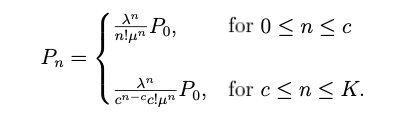

In [81]:
# дано
our_lambda = 12 #входная интенсивность задач
c = 3 #количество каналов
mu = 3 #интенсивность/скорость обслуживания канала
N = 3 #максимальная длина очереди
K = c+N #макс количество агентов в системе

# считаем
ro = our_lambda / mu

#  P_0 
x = 0
for n in range(c+1):
    x_1 = ro**n/math.factorial(n)
    x += x_1

y = 0
for i in range(1, K-c+1):
    y_1 = (ro/c)**i
    y += y_1 

p_null = round(1 / (x+(ro**c/math.factorial(c) * y)), 4)

#P_n
df_p = pd.DataFrame([[0, p_null]], columns=['n', 'p_n'])
for n in range(1, K+1):
    if n <= c:
        p = round((ro**n)/math.factorial(n) * p_null, 4)
    elif n > c:
        p = round(((ro**n)/math.factorial(c)) * ((1/c)**(n-c)) * p_null, 4)
    
    df = pd.DataFrame([[n, p]], columns=['n', 'p_n'])
    df_p = pd.concat([df_p, df]).reset_index(drop=True)

df_p

,n,p_n
0,0,0.0122
1,1,0.0488
2,2,0.0976
3,3,0.1301
4,4,0.1735
5,5,0.2313
6,6,0.3085


In [43]:
# The average arrival rate of customers who actually enter the system
p_k = df_p.iloc[6][1] #все каналы заняты и очередь наполнена, тогда p_k - это вероятность отказа (и вероятность, что у нас K клиентов в системе)
hat_lambda = our_lambda*(1-p_k)
hat_lambda

8.298

### $\bar{Q}$ - Среднее число заявок, находящихся в очереди

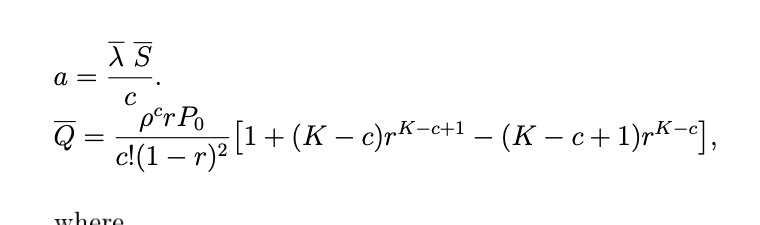

In [44]:
r = ro/c
q_hat = ( (ro**c * r * p_null)/(math.factorial(c) * (1-r)**2) ) * (1 + (K-c) * r**(K-c+1) - (K-c+1) * r**(K-c))
q_hat

1.5616000000000005

### $\bar{N}$ - Среднее число заявок, находящихся в СМО

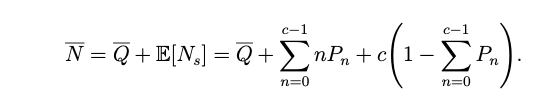

In [45]:
x, y = 0, 0
for n in range(c):
    x_1 = n * df_p.iloc[n][1]
    x += x_1
    y_1 = df_p.iloc[n][1]
    y += y_1
 
n_hat = round(q_hat + x + c*(1-y), 4)
n_hat

4.3298

### $\bar{W}, \bar{T}, \Pi_n$ (dist_arrival_null)

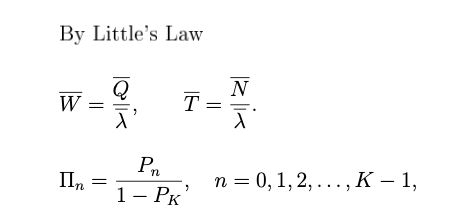

In [50]:
# Average waiting time
w_hat = q_hat / hat_lambda
w_hat

0.18818992528320083

In [55]:
# Mean response time
t_hat = n_hat / hat_lambda
t_hat

0.5217883827428296

In [226]:
# Distribution at the moment of arrival into the system
df_pp = df_p.copy()
df_pp['dist_arrival'] = 0
for i in df_pp['n']:
    df_pp.loc[df_pp['n'] == i, 'dist_arrival'] = df_pp.loc[df_pp['n'] == i, 'p_n'] / (1-p_k)

dist_arrival_null = df_pp.iloc[0][2]
df_pp

,n,p_n,dist_arrival
0,0,0.0122,0.017643
1,1,0.0488,0.070571
2,2,0.0976,0.141142
3,3,0.1301,0.188142
4,4,0.1735,0.250904
5,5,0.2313,0.334490
6,6,0.3085,0.446132


### Вероятность того, что вновь поступившая заявка немедленно будет принята к обслуживанию (p_nowtake)

In [67]:
# Вероятность того, что вновь поступившая заявка немедленно будет принята к обслуживанию 
# по сути это вероятность, что хотя бы один канал свободен, тогда это сумма вероятностей от p_0 до p_2
# не берем p_3 так как если все три канала заняты, то заявка не будет немедленно принята к обслуживанию
# плюс заметил, что сумма вероятностей нахождения во всех состояниях равна 1
p_nowtake = round(df_p.iloc[0][1] + df_p.iloc[1][1] + df_p.iloc[2][1], 4)
p_nowtake

0.1586

### $F_W(t)$ - Distribution of the waiting time, Закон распределения времени ожидания заявки в очереди

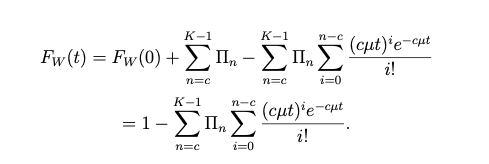

In [ ]:
def func_wait_time(t):
    x, y = 0, 0
    for i in range(c, K):
        x += df_pp.iloc[i][2]

    for i in range(n-c+1):
        y += ((c*mu*t)**i) * math.exp(-(c*mu*t)) / math.factorial(i)
    
    return 1 - x*y